In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve,roc_auc_score,auc, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier


In [ ]:
#formatage des données de training


df_train = pd.read_csv('Train_transformed.csv',  sep=';')
df_train = df_train.drop('Unnamed: 0', axis=1)

df_submission_test = pd.read_csv('Test_submission_transformed.csv', sep=';')
df_submission_test = df_submission_test.drop('Unnamed: 0', axis=1)

print("shape des données du Train.csv : {}".format(df_train.shape))
print("shape des données de Test.csv : {}".format(df_submission_test.shape))

df_train.drop_duplicates(subset= ['booking_id'], inplace= True)

df_train.set_index('booking_id', inplace= True)





In [3]:
X = df_train.drop('return90',axis=1)
y = df_train['return90']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 87)

In [36]:
import re

regex = re.compile(r"\[|\]|<|\\", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<','\\'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '\\'))) else col for col in X_test.columns.values]

In [37]:
X_train.head()

,is_hotel,good_for_family,accept_credit_card,parking,outdoor_seating,wifi,wheelchair_accessible,people,is_required_prepay_satisfied,isTest,...,member_city_新竹縣,member_city_桃園縣,member_city_澎湖縣,member_city_花蓮縣,member_city_苗栗縣,member_city_連江縣,member_city_金門縣,member_city_雲林縣,member_city_香港,member_city_高雄市
booking_id,,,,,,,,,,,,,,,,,,,,,
148162,1,1,1,1,0,1,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
69798,0,1,1,1,0,1,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
92353,0,1,1,1,0,1,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
86342,0,1,1,1,0,1,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0
135669,0,1,1,1,0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0


AUC: 0.6786141827625043


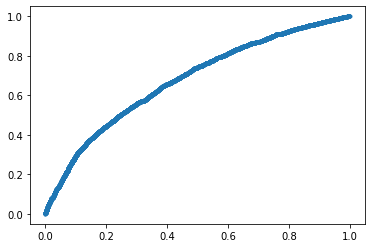

In [38]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV



xgb_params = {
            "eta": 0.1,
            "max_depth": 7,
            "gamma": 1,
            "min_child_weight": 1,
            "subsample": 0.5,
            "colsample_bytree": 0.8,
            "max_bin": 256,
            "objective": "binary:logistic",
            "tree_method": "hist",
            "silent": 1,
        }

params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
          "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
          "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

boost = xgb.XGBClassifier(eta=0.1, max_depth=7,gamma = 1, min_child_weight=1,subsample=0.5,colsample_bytree=0.8,
                          max_bin=256,objective = "binary:logistic",tree_method= "hist",silent=1)


#cv_random = RandomizedSearchCV(boost,params,n_iter= 5, random_state= 55)

#cv_random.fit(X_train, y_train)

#print(cv_random.best_params_)
#print(cv_random.best_score_)

boost.fit(X_train,y_train)

y_boost = boost.predict_proba(X_test)[:,1]


fpr, tpr, _ = roc_curve(y_test,y_boost)
plt.plot(fpr, tpr, marker='.', label='LogistiIIc')


print("AUC: {}".format(roc_auc_score(y_test, y_boost)))

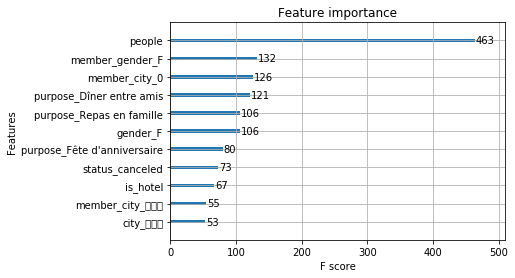

In [52]:
xgb.plot_importance(boost, max_num_features=11) # top 10 features
plt.show()

In [3]:
import re
import xgboost as xgb
X = df_train.drop('return90',axis=1)
y = df_train['return90']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 87)


regex = re.compile(r"\[|\]|<|\\", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<','\\'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<', '\\'))) else col for col in X_test.columns.values]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [4]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
}

In [5]:
params['eval_metric'] = "auc"
num_boost_round = 999

In [59]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.63923
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.64435
[2]	Test-auc:0.65134
[3]	Test-auc:0.65665
[4]	Test-auc:0.65978
[5]	Test-auc:0.66373
[6]	Test-auc:0.66456
[7]	Test-auc:0.66496
[8]	Test-auc:0.66740
[9]	Test-auc:0.66794
[10]	Test-auc:0.66905
[11]	Test-auc:0.66918
[12]	Test-auc:0.67202
[13]	Test-auc:0.67234
[14]	Test-auc:0.67273
[15]	Test-auc:0.67403
[16]	Test-auc:0.67478
[17]	Test-auc:0.67479
[18]	Test-auc:0.67520
[19]	Test-auc:0.67504
[20]	Test-auc:0.67490
[21]	Test-auc:0.67492
[22]	Test-auc:0.67533
[23]	Test-auc:0.67548
[24]	Test-auc:0.67546
[25]	Test-auc:0.67551
[26]	Test-auc:0.67568
[27]	Test-auc:0.67569
[28]	Test-auc:0.67555
[29]	Test-auc:0.67554
[30]	Test-auc:0.67577
[31]	Test-auc:0.67602
[32]	Test-auc:0.67572
[33]	Test-auc:0.67581
[34]	Test-auc:0.67565
[35]	Test-auc:0.67564
[36]	Test-auc:0.67555
[37]	Test-auc:0.67560
[38]	Test-auc:0.67553
[39]	Test-auc:0.67576
[40]	Test-auc:0.67603
[41]	Test-auc:0.67612
[42]	Test-auc:0.67589
[43]	Tes

In [60]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'auc'},
    early_stopping_rounds=10
)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.648657,0.001284,0.642657,0.002644
1,0.654989,0.002223,0.645590,0.003273
2,0.659344,0.001505,0.649810,0.004215
3,0.664936,0.001326,0.654244,0.004233
4,0.668210,0.000538,0.656359,0.003411
5,0.672814,0.001611,0.658685,0.003784
6,0.675719,0.001135,0.659244,0.004262
7,0.677377,0.001596,0.659845,0.004047
8,0.679139,0.001676,0.660862,0.004179
9,0.680773,0.001469,0.661327,0.004378


In [62]:
cv_results['test-auc-mean'].max()

0.6655570000000001

In [63]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]


# Define initial best params and MAE
max_auc = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tZUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=9, min_child_weight=5


/Users/jerem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


	ZUC 0.6610712 for 26 rounds
CV with max_depth=9, min_child_weight=6
	ZUC 0.6621792000000001 for 18 rounds
CV with max_depth=9, min_child_weight=7
	ZUC 0.661307 for 15 rounds
CV with max_depth=10, min_child_weight=5
	ZUC 0.6607476 for 19 rounds
CV with max_depth=10, min_child_weight=6
	ZUC 0.6599644 for 24 rounds
CV with max_depth=10, min_child_weight=7
	ZUC 0.6603174 for 30 rounds
CV with max_depth=11, min_child_weight=5
	ZUC 0.66099 for 14 rounds
CV with max_depth=11, min_child_weight=6
	ZUC 0.6609003999999999 for 19 rounds
CV with max_depth=11, min_child_weight=7
	ZUC 0.6610028 for 15 rounds
Best params: 9, 6, AUC: 0.6621792000000001


In [6]:
params['max_depth'] = 9
params['min_child_weight'] = 6

In [65]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

max_auc = 0
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'auc'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\AUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=1.0, colsample=1.0
\AUC 0.6621792000000001 for 18 rounds
CV with subsample=1.0, colsample=0.9
\AUC 0.6619455999999999 for 15 rounds
CV with subsample=1.0, colsample=0.8
\AUC 0.6619927999999999 for 20 rounds
CV with subsample=1.0, colsample=0.7
\AUC 0.6620524 for 21 rounds
CV with subsample=0.9, colsample=1.0
\AUC 0.6620342 for 15 rounds
CV with subsample=0.9, colsample=0.9
\AUC 0.6621737999999999 for 20 rounds
CV with subsample=0.9, colsample=0.8
\AUC 0.6620113999999999 for 17 rounds
CV with subsample=0.9, colsample=0.7
\AUC 0.6621852 for 20 rounds
CV with subsample=0.8, colsample=1.0
\AUC 0.6613278 for 12 rounds
CV with subsample=0.8, colsample=0.9
\AUC 0.6613822 for 15 rounds
CV with subsample=0.8, colsample=0.8
\AUC 0.6627805999999999 for 17 rounds
CV with subsample=0.8, colsample=0.7
\AUC 0.6624838000000001 for 22 rounds
CV with subsample=0.7, colsample=1.0
\AUC 0.6613595999999999 for 12 rounds
CV with subsample=0.7, colsample=0.9
\AUC 0.661467 for 12 rounds
CV wi

In [7]:
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

In [8]:
%time

max_auc = 0
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['auc'],early_stopping_rounds=10)
    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].idxmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, max_auc))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs
CV with eta=0.3
CPU times: user 5min 22s, sys: 1.01 s, total: 5min 23s
Wall time: 5min 23s
	AUC 0.6627805999999999 for 17 rounds

CV with eta=0.2
CPU times: user 6min 16s, sys: 1 s, total: 6min 17s
Wall time: 6min 17s
	AUC 0.6631388 for 22 rounds

CV with eta=0.1
CPU times: user 5min 32s, sys: 990 ms, total: 5min 33s
Wall time: 5min 33s
	AUC 0.6634971999999999 for 18 rounds

CV with eta=0.05
CPU times: user 11min 16s, sys: 1.11 s, total: 11min 17s
Wall time: 11min 17s
	AUC 0.663796 for 49 rounds

CV with eta=0.01
CPU times: user 54min 34s, sys: 2.04 s, total: 54min 36s
Wall time: 54min 37s
	AUC 0.6649706 for 283 rounds

CV with eta=0.005
CPU times: user 6min 41s, sys: 947 ms, total: 6min 42s
Wall time: 6min 42s
	AUC 0.6612698 for 24 rounds

Best params: 0.01, AUC: 0.6649706


In [9]:
params['eta'] = 0.01

In [17]:
#training du model avec les params optimaux

model = xgb.XGBClassifier(max_depth = params['max_depth'],
                          min_child_weight = params['min_child_weight'],
                          subsample = params['subsample'],
                          colsample_bytree = params['colsample_bytree'],
                          eta = params['eta'],
                          early_stopping_rounds=10,
                          num_boost_round=num_boost_round,
                          seed=42,
                          nfold=5,
                          metrics={'auc'},
                         )



AUC: 0.6710932506833421


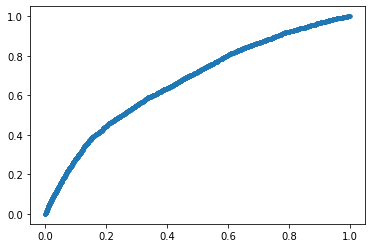

In [19]:
#predicting

model.fit(X_train, y_train)

y_predict_xgb_tuned = model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test,y_predict_xgb_tuned)
plt.plot(fpr, tpr, marker='.', label='LogistiIIc')


print("AUC: {}".format(roc_auc_score(y_test, y_predict_xgb_tuned)))

training
[LibLinear]end training
AUC: 0.6754760924465991


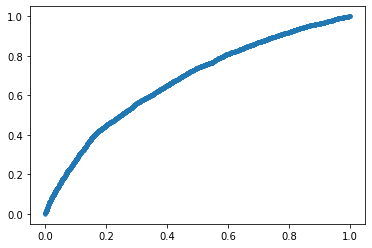

In [15]:
params = clf.best_params_
params


blr = LogisticRegression(C = params['classifier__C'], class_weight = None, dual = False, fit_intercept = True,
                         intercept_scaling = 1, l1_ratio = None, max_iter= 100, multi_class = 'auto',
                         n_jobs= None, penalty='l1', random_state = 22, solver= 'liblinear', tol= 0.0001,
                         verbose=2, warm_start= False)


print("training")
blr.fit(X_train,y_train)
print("end training")

y_p_blr = blr.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test,y_p_blr)
plt.plot(fpr, tpr, marker='.', label='LogistiIIc')


print("AUC: {}".format(roc_auc_score(y_test, y_p_blr)))

In [25]:
print(y_ada_pred)

[0 0 0 ... 0 0 0]


In [29]:
#### executer la cellule d'en dessous -- attention va prendre du temps

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)



print("fitting")

rf_random.fit(X_train, y_train)
print("end fitting")

y_pred_res = rf_random.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test,y_pred_res)
plt.plot(fpr, tpr, marker='.', label='LogistiIIc')


print("AUC: {}".format(roc_auc_score(y_test, y_pred_res)))

In [25]:
#resampling using smote de imblearn
from imblearn.combine import SMOTETomek

df_train_sample = df_train.sample(n = 34000, random_state=42)

X_sample = df_train_sample.drop('return90',axis=1)
y_sample = df_train_sample['return90']


print("début resampling")
smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_sample(X_sample, y_sample)
print("fin resampling")



début resampling
fin resampling


In [27]:
#il faudrait extraire les infos interressante des dates en rajoutant des colones binaires telles que : 
# weekends vs weekdays business hours and time of day
#seasons
#week of year number
#month
#year
#beginning/end of month (pay days)
#quarter
#days to/from an action event(distance)

X['cdate'] = pd.DatetimeIndex(X['cdate']).astype(np.int64)
X['datetime'] = pd.DatetimeIndex(X['datetime']).astype(np.int64)
X = X.drop(['cdate','datetime'], axis = 1)

(77983, 719)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 66.7min finished


Parametre C tuné du model: {'C': 0.05179474679231213}
Meilleur score 0.7995896534036785
fitting
end fitting
AUC: 0.6779176125843276


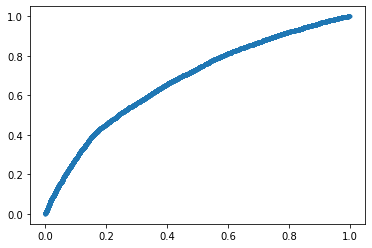

In [43]:
from sklearn.model_selection import RandomizedSearchCV
lr_date = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio= 0, max_iter = 3000)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 87)

print(X.shape)

c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

logreg_cv = RandomizedSearchCV(lr_date, param_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)


logreg_cv.fit(X_train,y_train)

#Meilleur parametre C
bestparam = logreg_cv.best_params_


print("Parametre C tuné du model: {}".format(bestparam)) 
print("Meilleur score {}".format(logreg_cv.best_score_))

lr_date_tuned = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio= 0, max_iter = 3000,
                                   C = bestparam['C'])



print("fitting")

lr_date_tuned.fit(X_train,y_train)

print("end fitting")

y_lr_date_predict = lr_date_tuned.predict_proba(X_test)[:,1]



fpr, tpr, _ = roc_curve(y_test,y_lr_date_predict)
plt.plot(fpr, tpr, marker='.', label='LogistiIIc')


print("AUC: {}".format(roc_auc_score(y_test, y_lr_date_predict)))

In [25]:
#resampling data car on a affaire à un dataset unbalanced avec plus de0 que de 1 dans le return 90 ( 80:20)

count_class_0, count_class_1 = df_train.return90.value_counts()

#division par classe
df_class_0 = df_train[df_train['return90']==0]
df_class_1 = df_train[df_train['return90']==1]

#random under sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under,df_class_1], axis = 0)
print(df_test_under.return90.value_counts())

1    15613
0    15613
Name: return90, dtype: int64


In [26]:
X_under_sampling = df_test_under.drop('return90', axis=1)
y_under_sampling = df_test_under['return90']


In [47]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier(random_state=500)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state= 60)



#critere
criterion = ['gini', 'entropy']

# nombre de features à chaque split
max_features = ['auto', 'sqrt','log2']
# nombre max d'etage pour chaque arbre
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# nombre mini pour split un noeud
min_samples_split = [2, 5, 10]
# nombre mini pour chaque feuille
min_samples_leaf = [1, 2, 4]
# methode de selection des sous ensemble du dataset

#grille pour les test des parametres optimaux

random_grid = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }





# 3 folds, 10 iterations = 30 test = env 8min sur le datasets sans reduction de dimensionnalités
rf_random = RandomizedSearchCV(estimator = clf_dt, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)


rf_random.fit(X_train, y_train)

bestparam = rf_random.best_params_


print("Parametre C tuné du model: {}".format(bestparam)) 
print("Meilleur score {}".format(rf_random.best_score_))






Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s


Parametre C tuné du model: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
Meilleur score 0.7977943870447718


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.9s finished


predicting ...
AUC: 0.6316119856722038


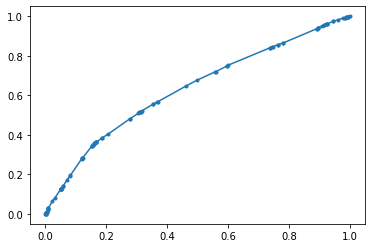

In [48]:
dt = DecisionTreeClassifier(min_samples_split = bestparam['min_samples_split'],
                            min_samples_leaf = bestparam['min_samples_leaf'],
                            max_features = bestparam['max_features'],
                            max_depth =  bestparam['max_depth'],
                            criterion = bestparam['criterion'],
                            random_state=500)

dt.fit(X_train,y_train)


print('predicting ...')

y_p_dt = dt.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test,y_p_dt)
plt.plot(fpr, tpr, marker='.', label='LogistiIIc')


print("AUC: {}".format(roc_auc_score(y_test, y_p_dt)))


fitting...


/Users/jerem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jerem/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fin fitting
AUC: 0.6124567973907604


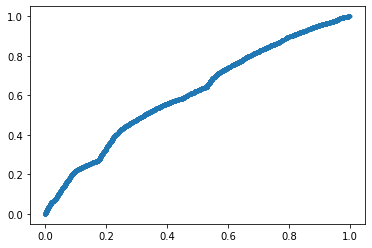

In [51]:
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


clf_meta = LogisticRegression(random_state=500)

clf_nb = GaussianNB()
k = KNeighborsClassifier(n_neighbors = 4)

clf_stack = StackingClassifier(classifiers=[test_rl,dt, clf_nb,k],
                               meta_classifier=clf_meta,
                               use_features_in_secondary=False,
                               use_probas = True)


print("fitting...")
clf_stack.fit(X_train,y_train)
print("fin fitting")

y_pred_stack = clf_stack.predict_proba(X_test)[:,1]


fpr, tpr, _ = roc_curve(y_test,y_pred_stack)
plt.plot(fpr, tpr, marker='.', label='LogistiIIc')


print("AUC: {}".format(roc_auc_score(y_test, y_pred_stack)))

In [20]:
X_df_sub = df_submission_test.drop('return90', axis = 1)
X_df_sub.set_index('booking_id', inplace= True)
#X_df_sub_reduc = X_df_sub.loc[:, model_reduc.get_support()]


regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_df_sub.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_df_sub.columns.values]
X_df_sub.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_df_sub.columns.values]


y_pred_sub = model.predict_proba(X_df_sub)[:,1]
print(y_pred_sub)


#index = X_df_sub_reduc['booking_id'].astype(np.int64)
submission_df = pd.DataFrame({'return90': y_pred_sub},index=X_df_sub.index)

submission_df.to_csv('submission11.csv',sep=',')

[0.42192262 0.42105013 0.4368787  ... 0.30835393 0.2734128  0.25517428]
